# Chinese Singer Classification Notebook

## Importing Libraries

In [3]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\21548\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\21548\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\21548\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\21548\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Extracting the Spectrogram for every Audio

In [8]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
save_dir=os.path.join(r'E:\Data\ChineseData\SpectrogramData')
wave_file=os.listdir(r'E:\Data\ChineseData\WaveDataset')
for index, wav in enumerate(wave_file):
    if index <73:
        continue
    file_path = f'E:/Data/ChineseData/WaveDataset/{wav}'
    try:
        y, sr=librosa.load(file_path,mono=True,offset=60,duration=60)
    except:
        continue
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB')
    plt.axis('off')
    file_id=wav.split('.')[0]
    file_name=file_id+".png"
    plt.savefig(os.path.join(save_dir,file_name))
    plt.clf()

<Figure size 720x720 with 0 Axes>

All the audio files get converted into their respective spectrograms .WE can noe easily extract features from them.

## Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [9]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

## Writing data to csv file

We write the data to a csv file 

In [ ]:
label = {}
with open(r'E:\Data\ChineseData\annotation.txt', 'r') as f:
    for line in f.readlines():
        seg = line.rstrip('\n').split(' ')
        label[seg[0]] = seg[1]

In [24]:
file = open(r'E:\Data\ChineseData\data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for filename in wave_file:
    songname = f'E:/Data/ChineseData/WaveDataset/{filename}'
    try:
        y, sr=librosa.load(songname,mono=True,offset=60,duration=60)
    except:
        continue
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    for e in mfcc:
        to_append += f' {np.mean(e)}'
    to_append += f' {label[filename]}'
    file = open(r'E:\Data\ChineseData\data.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

The data has been extracted into a [data.csv](https://github.com/parulnith/Music-Genre-Classification-with-Python/blob/master/data.csv) file.

# Analysing the Data in Pandas

In [25]:
data = pd.read_csv(r'E:\Data\ChineseData\data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.wav,0.431378,0.199305,2292.988524,2591.975580,5262.301513,0.087465,-60.342373,84.354149,2.813634,...,9.971762,1.923018,2.397544,-0.702888,0.217624,-3.280695,3.472342,-4.312668,1.800327,0
1,1.wav,0.378815,0.218430,2408.813174,2556.016084,5197.456072,0.100745,-45.908920,85.624115,-1.778882,...,5.990713,-3.984214,8.866004,-1.053132,2.946227,-1.518717,5.766772,0.453489,8.956429,0
2,10.wav,0.360899,0.188289,1857.597344,2327.786544,4034.900602,0.067977,-119.347572,108.595215,21.491800,...,11.071996,-4.530415,2.519861,-4.387146,-2.890145,-4.872740,1.766777,-4.811665,3.598597,0
3,100.wav,0.333033,0.183311,1615.338791,2109.451085,3422.966802,0.068089,-98.651489,131.358276,2.993919,...,3.610813,-1.469699,3.402382,-0.699494,5.911116,-3.102954,4.852661,-5.273423,2.329937,1
4,101.wav,0.354197,0.101389,2309.660354,2591.067612,5189.668619,0.089040,-123.439873,93.278275,6.665424,...,0.850279,-5.320220,-0.595196,-8.889750,3.647707,-10.047231,2.864072,-5.436964,-1.346193,1


In [26]:
data.shape

(500, 28)

In [27]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

## Encoding the Labels

In [29]:
# genre_list = data.iloc[:, -1]
# encoder = LabelEncoder()
# y = encoder.fit_transform(genre_list)
y = data.iloc[:, -1]
y

0      0
1      0
2      0
3      1
4      1
      ..
495    1
496    1
497    1
498    1
499    1
Name: label, Length: 500, dtype: int64

## Scaling the Feature columns

In [30]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## Dividing data into training and Testing set

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
len(y_train)

400

In [33]:
len(y_test)

100

In [34]:
X_train[10]

array([ 0.39134841, -1.3866332 , -0.78610862, -0.60854285, -0.75992456,
       -0.8049317 , -1.25711632,  0.80826881,  0.68111527,  0.99256325,
        0.41551105, -0.23251548,  1.32189284,  0.56335387, -1.79562721,
        1.74475754, -1.1719416 ,  0.33126953,  0.09790712, -1.28964863,
        0.82642702, -0.04321343, -1.0031176 ,  1.06928186, -0.32268292,
        1.14169132])

# Classification with Keras

## Building our Network

In [311]:
from keras import models
from keras import layers
from keras.optimizers import Adam

np.random.seed(0)
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

# model.add(layers.Dense(64, activation='relu'))

# model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(9, activation='softmax'))

In [312]:
model.compile(optimizer=Adam(0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [313]:
history = model.fit(X_train,
                    y_train,
                    epochs=110,
                    batch_size=32)

Epoch 1/110
400/400 [==============================] - 0s 748us/step - loss: 2.2657 - accuracy: 0.1100
Epoch 2/110
400/400 [==============================] - 0s 52us/step - loss: 2.1290 - accuracy: 0.1925
Epoch 3/110
400/400 [==============================] - 0s 50us/step - loss: 2.0219 - accuracy: 0.2825
Epoch 4/110
400/400 [==============================] - 0s 52us/step - loss: 1.9230 - accuracy: 0.3500
Epoch 5/110
400/400 [==============================] - 0s 62us/step - loss: 1.8354 - accuracy: 0.4000
Epoch 6/110
400/400 [==============================] - 0s 57us/step - loss: 1.7574 - accuracy: 0.4525
Epoch 7/110
400/400 [==============================] - 0s 61us/step - loss: 1.6823 - accuracy: 0.4900
Epoch 8/110
400/400 [==============================] - 0s 62us/step - loss: 1.6133 - accuracy: 0.5400
Epoch 9/110
400/400 [==============================] - 0s 52us/step - loss: 1.5495 - accuracy: 0.5725
Epoch 10/110
400/400 [==============================] - 0s 65us/step - loss: 1.48

In [314]:
test_loss, test_acc = model.evaluate(X_test,y_test)

100/100 [==============================] - 0s 3ms/step


In [315]:
print('test_acc: ',test_acc)

test_acc:  0.7599999904632568


Tes accuracy is less than training dataa accuracy. This hints at Overfitting

# SVM

In [69]:
from sklearn.svm import SVC
from sklearn import metrics
# svm_model=SVC(kernel='sigmoid')
# svm_model.fit(X_train,y_train)
# y_predict=svm.
kernelList = ['linear','rbf','sigmoid']         

for kernel in kernelList:
    svc = SVC(kernel=kernel).fit(X_train,y_train)
    y_pred = svc.predict(X_test)
    score_svc = metrics.accuracy_score(y_test,y_pred)
    print(score_svc)

0.74
0.66
0.66


gamma=0.01时,得分最高=0.7


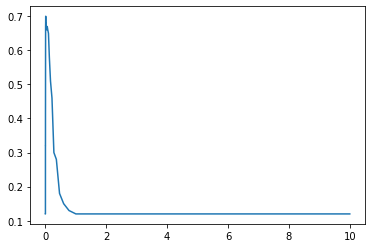

In [74]:
score_gamma=[]
gammaList=np.logspace(-10,1,100)

for gamma in gammaList:
    svc = SVC(gamma=gamma, kernel='rbf').fit(X_train,y_train)
    score_gamma.append(svc.score(X_test,y_test))

print('gamma={}时,得分最高={}'.format(gammaList[score_gamma.index(max(score_gamma))],max(score_gamma)))

plt.plot(gammaList,score_gamma)

# Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
rf_model = RandomForestClassifier(n_estimators = 10, criterion="gini",max_depth=4)
rf_model.fit(X_train, y_train)
acu_train = rf_model.score(X_train, y_train)
acu_test = rf_model.score(X_test, y_test)
y_pred = rf_model.predict(X_test)
recall = recall_score(y_test, y_pred, average="macro")
result = {
              "k":[],
              "auc_train": [],
              "auc_test": [],
              "recall": []
              }
result["k"].append(10)
result["auc_train"].append(acu_train)
result["auc_test"].append(acu_test)
result["recall"].append(recall)
result

{'k': [10],
 'auc_train': [0.705],
 'auc_test': [0.43],
 'recall': [0.39148860398860397]}